In [1]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
from MattDataCleaning import midwest_metromurders_0509

    Population MSA Code                                      MSA     State
0     571519.0    49660        Youngstown-Warren-Boardman, OH-PA     OH-PA
1     596643.0    48620                              Wichita, KS        KS
2     145942.0    48540                          Wheeling, WV-OH     WV-OH
3     122778.0    48260              Weirton-Steubenville, WV-OH     WV-OH
4     129803.0    48140                               Wausau, WI        WI
5     163040.0    47940                 Waterloo-Cedar Falls, IA        IA
6     228761.0    45820                               Topeka, KS        KS
7     673545.0    45780                               Toledo, OH        OH
8     169733.0    45460                          Terre Haute, IN        IN
9     140419.0    44220                          Springfield, OH        OH
10    417635.0    44180                          Springfield, MO        MO
11    206509.0    44100                          Springfield, IL        IL
12    316883.0    43780  

In [2]:
# Multiply murder counts by 100000 then divide by populations for each city to get per capita murder rates
midwest_metromurders_0509['Per capita murder rate, 2005-2009'] = \
midwest_metromurders_0509['Murders 2005-2009'] * 100000 / midwest_metromurders_0509['Population 2009']

# Round and reset index
midwest_metromurders_0509 = midwest_metromurders_0509.round(2).reset_index(drop=True)
midwest_metromurders_0509

/Users/matthewhanson/anaconda3/envs/PythonData/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Metro area,Population 2009,Murders 2005-2009,"Per capita murder rate, 2005-2009"
0,"Akron, OH",700222.0,145.0,20.71
1,"Ames, IA",84780.0,7.0,8.26
2,"Anderson, IN",131015.0,19.0,14.50
3,"Ann Arbor, MI",346007.0,44.0,12.72
4,"Appleton, WI",218014.0,10.0,4.59
5,"Battle Creek, MI",136875.0,49.0,35.80
6,"Bay City, MI",107778.0,10.0,9.28
7,"Bismarck, ND",102899.0,10.0,9.72
8,"Bloomington, IN",182941.0,19.0,10.39
9,"Bloomington-Normal, IL",163686.0,5.0,3.05


In [3]:
# Prep data for scatter plot by making metro areas the index 
midwest_metromurders_scatter = midwest_metromurders_0509.set_index('Metro area')

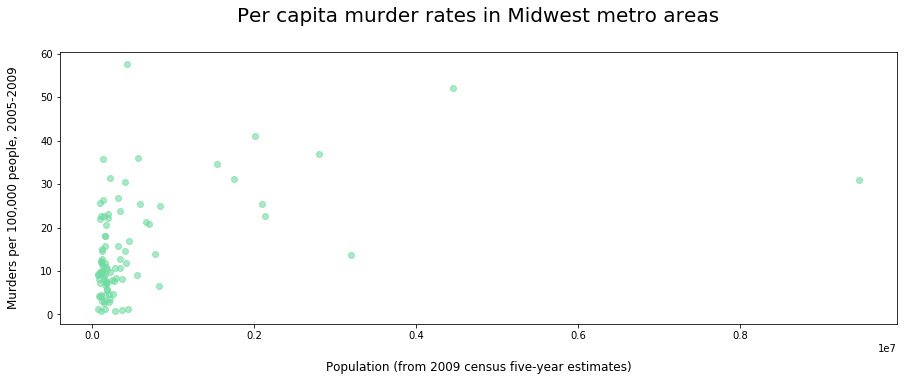

In [25]:
x = midwest_metromurders_scatter['Population 2009']
y = midwest_metromurders_scatter['Per capita murder rate, 2005-2009']
plt.figure(figsize=(15,5))
plt.scatter(x, y, color='#6EDBA1', alpha=0.6)
plt.title('Per capita murder rates in Midwest metro areas', pad=30, fontname='Chaparral Pro', fontsize=20)
plt.xlabel('Population (from 2009 census five-year estimates)', labelpad=20, fontname='Chaparral Pro', fontsize=12)
plt.ylabel('Murders per 100,000 people, 2005-2009', labelpad=20, fontname='Chaparral Pro', fontsize=12)

plt.savefig('Project1_Final/images/percapitamurderrates.png')

In [26]:
midwest_top10_murderrates = midwest_metromurders_0509.nlargest(10, 'Per capita murder rate, 2005-2009')
midwest_top10_murderrates = midwest_top10_murderrates[['Metro area', 'Per capita murder rate, 2005-2009']].reset_index(drop=True)
midwest_top10_murderrates

,Metro area,"Per capita murder rate, 2005-2009"
0,"Flint, MI",57.54
1,"Detroit-Warren-Livonia, MI",52.19
2,"Kansas City, MO-KS",41.02
3,"St. Louis, MO-IL",36.81
4,"Youngstown-Warren-Boardman, OH-PA",36.04
5,"Battle Creek, MI",35.80
6,"Milwaukee-Waukesha-West Allis, WI",34.66
7,"Topeka, KS",31.47
8,"Columbus, OH",31.22
9,"Chicago-Naperville-Joliet, IL-IN-WI",30.88


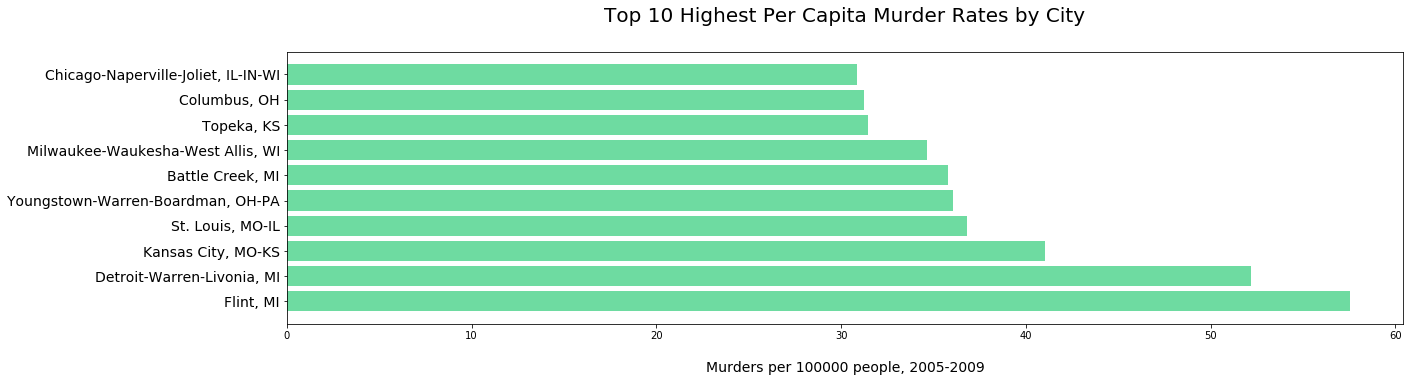

In [27]:
plt.figure(figsize=(20,5))
y_axis = np.arange(len(midwest_top10_murderrates))
tick_locations = [value for value in y_axis]
plt.barh(y_axis, midwest_top10_murderrates['Per capita murder rate, 2005-2009'], color='#6EDBA1')
plt.yticks(tick_locations, midwest_top10_murderrates['Metro area'], rotation='horizontal', fontsize=14)
plt.title('Top 10 Highest Per Capita Murder Rates by City', pad=30, fontsize=20)
plt.xlabel('Murders per 100000 people, 2005-2009', labelpad=20, fontsize=14)

plt.savefig('Project1_Final/images/top10metromurderrates.png')